In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

    
from logger import *
setup_logging(default_level=logging.INFO)

from sklearn import manifold, datasets
from sklearn.utils import check_random_state


from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from algo.fa import LinearQ3
from algo.apprenticeship_learning import ApprenticeshipLearning as AL
from env.simulator import * 
from util.plotting import *
from util.basis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = range(env.action_space.n)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
# default
s_init = [-0.5, 0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)
print(env.reset([-.3, 0.3]))

[-0.3  0.3]


## define simulator

In [5]:
include_action = False
# if this is True, then the state space becomes very large
# therefore, a more denser, higher number of phi is needed

p_linear = 2 * n_action
q_linear = 2 * n_action
phi_linear = LinearKernel2(p_linear, n_action, include_action).transform
psi_linear = phi_linear

n_component = 15
gamma_list = [0.5, 5.0, 10.0, 20.0]
p_rbf =  n_component * len(gamma_list) * n_action
q_rbf = n_component * len(gamma_list) * n_action

# technically the truly-batch mode should use D to fit rbf kenel
phi_rbf = RBFKernel2(env, n_action, p_rbf, n_component, gamma_list, include_action).transform
psi_rbf = phi_rbf

precision = 1e-2
eps = 0.0
gamma = 0.99

/home/dhfromkorea/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 199 @ Episode 100/100 (-161.0)

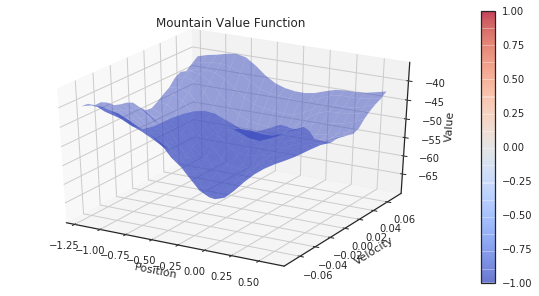

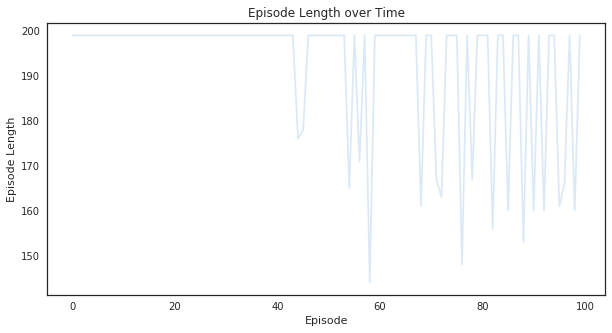

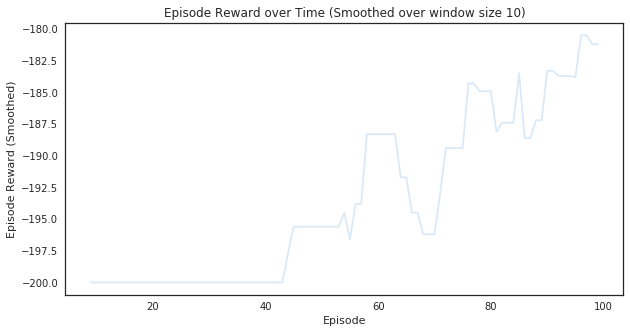

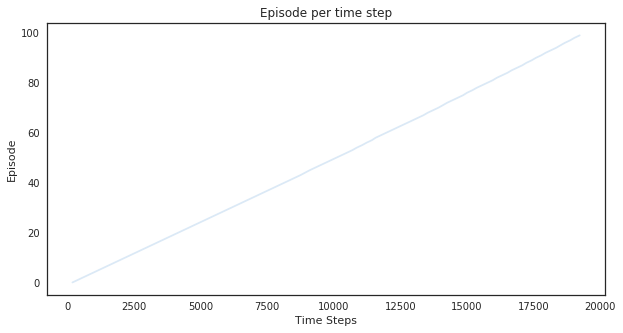

(<matplotlib.figure.Figure at 0x7fdff29b9c88>,
 <matplotlib.figure.Figure at 0x7fdff296aac8>)

In [23]:
phi = phi_rbf
p = p_rbf

mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      p=p,
                      action_list=action_list,
                      n_episode=100,
                      epsilon=0.0,
                      epsilon_decay=1.00,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve(reward_fn=None)
plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)

## generate trajectories under expert policy (=D)

In [6]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        c = 0
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        return 0 if v > c else 2
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)


In [8]:

# todo: purify
pi_list = [pi_random, pi_near_ops, pi_near, pi_expert]
mix_ratio = [0.1, 0.1, 0.1, 0.7]
sample_size = 100
D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)
D_mat = Simulator.to_matrix(D)

Step 88 @ Episode 50/50 (-88.0)))

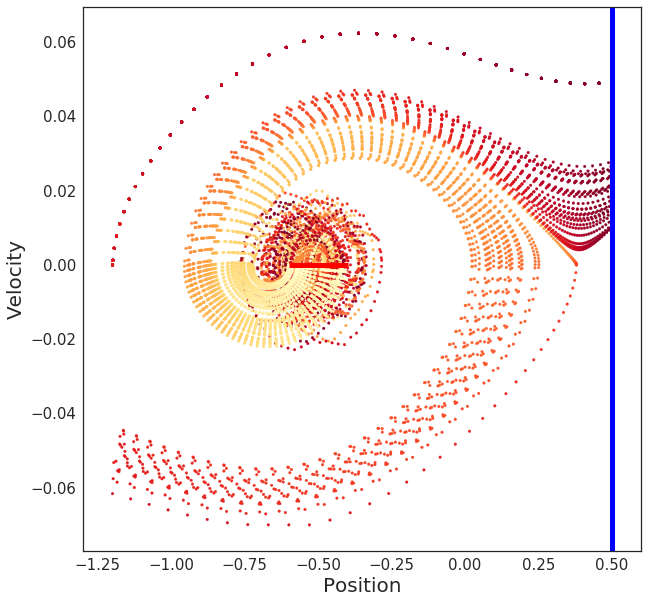

In [9]:
plot_trajectory_mountain_car(D)

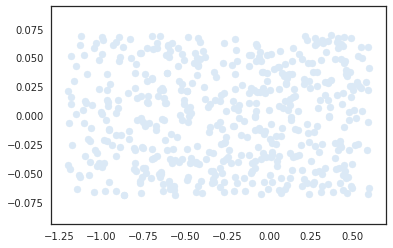

In [14]:
samples=np.array([env.observation_space.sample() for _ in range(500)])
plt.scatter(samples[:, 0], samples[:, 1])

## compare Mu_mc to Mu_lstd
- given a set of initial points
- mu_mc obtained from simulatation
- mu_lstd learned from D
- both linear and rbf

In [20]:
# define policy to evaluate
# easy
#pi_eval = pi_expert
# easy
pi_eval = pi_near
# difficult (likely)
#pi_eval = pi_near_ops

# set of initial points to test for
zeros = np.zeros(20)
s_init_list = np.array([ [pos, v] for pos, v in zip(np.linspace(-0.6, -0.4, 20), zeros)])

## run mu_mc with linear

In [33]:
# montecarlo roll outs
sample_size_mc = 50

mu_mc_linear = {}
for s_init in s_init_list:
    mu_mc, epi_len = AL.estimate_mu(env=env,
                            pi_eval=pi_eval,
                            mu_sample_size=sample_size_mc,
                            phi=phi_linear,
                            gamma=gamma,
                            return_epi_len=True,
                            s_init=s_init)
    mu_mc_linear[tuple(s_init)] = mu_mc

INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples
INFO:root:estimating mu with 50 samples


KeyboardInterrupt: 

## run_mu_lstd with linear

In [21]:
# depends on basis function
eps = 0.0000
mu_lstd_linear = {}
for s_init in s_init_list:
    lm_linear = LSTDMu(p=p_linear, q=q_linear, phi=phi_linear, psi=psi_linear, gamma=gamma, eps=eps)
    lm_linear.fit(D=D_mat, pi=pi_eval)
    mu_lstd = lm_linear.predict(s_init, pi_eval.choose_action(s_init))
    mu_lstd_linear[tuple(s_init)] = mu_lstd


## run mu_mc with rbf

In [62]:
# montecarlo roll outs
sample_size_mc = 50

# set of initial points to test for
s_init_list = np.linspace(-0.6, -0.4, 20)
mu_mc_rbf = {}
for s_init in s_init_list:
    mu_mc, epi_len = AL.estimate_mu(env=env,
                            pi_eval=pi_eval,
                            mu_sample_size=sample_size_mc,
                            phi=phi_rbf,
                            gamma=gamma,
                            return_epi_len=True,
                            s_init=s_init)
    mu_mc_rbf[tuple(s_init)] = mu_mc

INFO:root:estimating mu with 50 samples


## run_mu_lstd with rbf

In [23]:
# depends on basis function
eps = 0.0000
mu_lstd_rbf = {}
for s_init in s_init_list:
    lm_rbf = LSTDMu(p=p_rbf, q=q_rbf, phi=phi_rbf, psi=psi_rbf, gamma=gamma, eps=eps)
    lm_rbf.fit(D=D_mat, pi=pi_eval)
    mu_lstd = lm_rbf.predict(s_init, pi_eval.choose_action(s_init))
    mu_lstd_rbf[tuple(s_init)] = mu_lstd

INFO:root:condition number of A_hat
1.1666383635884895e+18
../algo/lstd.py:183: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xi_hat = lstsq(A_hat, b_hat)[0]
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:condition number of A_hat
1.1666383635884895e+18
INFO:root:cond

In [ ]:
def compare_mc_lstd(s_init_list, mu_mc_linear, mu_lstd_linear, mu_mc_rbf, mu_lstd_rbf):
    dist_list_linear = []
    dist_list_rbf = []
    for s_init in s_init_list:
        dist = np.linalg.norm(mu_mc_linear[s_init] - mu_lstd_linear[s_init], 2)
        dist_list_linear.append(dist)
        dist = np.linalg.norm(mu_mc_rbf[s_init] - mu_lstd_rbf[s_init], 2)
        dist_list_rbf.append(dist)

    ax = plt.gca()
    ax.plot(s_init, dis_list_linear, label="linear l2 norm")
    ax.plot(s_init, dist_list_rbf, label="rbf l2 norm")
    ax.legend()
    plt.show()
    
compare_mc_lstd(s_init_list, mu_mc_linear, mu_lstd_linear, mu_mc_rbf, mu_lstd_rbf)

## Visualize Monte Carlo $\mu$ of evaluation policy

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_mc_rbf).T

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Monte Carlo Estimates')

ax1.scatter(mus_mc_linear[:, 0], mus_mc_linear[:, 1])
ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

# c= ..
ss = ax2.scatter(trans_data[0], trans_data[1])
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=ax2)
plt.show()
                 
# u_hat= 1/n sum_{i=1}^n (u_i)
# E[u_hat] = u
                

## LSTD-mu estimation of evaluation policy
- with linear basis
- with rbf basis

In [ ]:
#pp(np.mean(mus, axis=0))
mus_lstd_linear = []
mus_lstd_rbf = []

for s0 in ss_init:
    # linear
    mu = lm_linear.predict(s0, pi5.choose_action(s0))
    mus_lstd_linear.append(mu)
    # rbf
    mu_rbf = lm_rbf.predict(s0, pi5.choose_action(s0))
    mus_lstd_rbf.append(mu)

mus_lstd_linear = np.array(mus_lstd_linear).squeeze()
mus_lstd_rbf = np.array(mus_lstd_rbf).squeeze()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Distribution of mu expert')

ax1.scatter(mus_lstd_linear[:, 0], mus_lstd_linear[:, 1])
#ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_lstd_rbf).T

ss = ax2.scatter(trans_data[0], trans_data[1], cmap='Reds')
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=[ax1, ax2])
plt.show()

## apply apprenticeship learning

In [ ]:
## value margin

In [ ]:
results = np.load("data/res_1522884923.4368284")
pi_irl_list = results['solutions']
D_irl = sim.simulate(pi_irl_list[0], n_trial=1, n_episode=50)

In [ ]:
pi_irl_list[0]._phi([0.5, 0.2], 1)

In [ ]:
sns.set(style='white', palette='Blues')

fig = plt.figure(figsize=(10, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

ax = plt.gca()
lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
c = np.array([(1, 0, 0, 1)])
lc = mc.LineCollection(lines, colors='red', linewidths=5)
ax.add_collection(lc)
for episode in D_irl:
    states = []
    for (s, a, r, s_next, done) in episode:
        states.append(s)
    states = np.array(states)
    sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
#ax.axis([-1.2,0.6,-0.07,0.07])
ax.axvline(0.5, c='blue', linewidth=5)
ax.set_xlabel('Position', fontsize=20.0)
ax.set_ylabel('Velocity', fontsize=20.0)
#plt.colorbar(sc)
plt.show()


In [ ]:
from matplotlib import collections  as mc

sns.set(style='white', palette='Blues')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

titles = ["Near-expert policy trajectories", "IRL poilcy trajectories"]
for title, ax, trajs_irl in zip(titles, axes, [trajs_expert_near, D_irl]):
    lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
    c = np.array([(1, 0, 0, 1)])
    lc = mc.LineCollection(lines, colors='red', linewidths=5)
    ax.set_title(title, fontsize=20.0)

    ax.add_collection(lc)
    for episode in trajs_irl:
        states = []
        try:
            for s, a, r, s_next, done in episode:
                states.append(s)
        except:
            import pdb;pdb.set_trace()
        states = np.array(states)
        sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
    #ax.axis([-1.2,0.6,-0.07,0.07])
    ax.axvline(0.5, c='blue', linewidth=5)
    ax.set_xlabel('Position', fontsize=20.0)
    ax.set_ylabel('Velocity', fontsize=20.0)
    #plt.colorbar(sc)
plt.show()


In [ ]:
margin_v_collection = results['margin_v']
margin_mu_collection = results['margin_mu']
mu_collection = results['mu']

In [ ]:
ax = plt.gca()
print('e')
for mu_list in mu_collection:
    mu_list = np.array(mu_list)
    #ax.scatter(mu_list[:, 0], mu_list[:, 1], c = range(len(mu_list[:,1])), cmap=plt.get_cmap("YlOrRd"))

mu_exp_list = np.array(estimate_mu_mc(env, pi_expert_near, phi_linear, gamma, 1000))
mu_exp = mu_exp_list.mean(axis=0)
ax.scatter(mu_exp[0], mu_exp[1], c='b')

In [ ]:
print(mu_exp_list.mean(axis=0).shape)
print(mu_exp_list.mean(axis=1)[1])

In [ ]:
from scipy.stats import sem
D_v = np.array(margin_v_collection)
mu_hat = np.mean(D_v, axis=0)
s = sem(D_v, axis=0)
ax = plt.gca()
ax.errorbar(np.arange(D_v.shape[1]), mu_hat, yerr=s, fmt="--o", c='g')
ax.set_title('value margin')
plt.show()

In [ ]:
from scipy.stats import sem
D_mu = np.array(margin_mu_collection)
mu_hat = np.mean(D_mu, axis=0)
s = sem(D_mu, axis=0)
ax = plt.gca()
ax.set_title('feature expectation margin')
ax.errorbar(np.arange(D_mu.shape[1]), mu_hat, yerr=s, fmt="--o", c='b')
plt.show()

In [ ]:
import pickle
from time import time
with open("data/res_{}.pkl".format(time()), "wb") as f:
    pickle.dump({'name': 'james'}, f, protocol=pickle.HIGHEST_PROTOCOL)


##
- number of samples
- fitted reward vs. true reward
- violation of actions
- trajectory matching
- margin

